In [1]:

import numpy as np
from numpy.random import rand
from numpy import ix_
import pandas as pd
np.random.seed(1337)


#%%
def bootstrap_sample(data, B, w):
    '''
    Bootstrap the input data
    data: input numpy data array
    B: boostrap size
    w: block length of the boostrap
    '''
    t = len(data)
    p = 1 / w
    indices = np.zeros((t, B), dtype=int)
    indices[0, :] = np.ceil(t * rand(1, B))
    select = np.asfortranarray(rand(B, t).T < p)
    vals = np.ceil(rand(1, np.sum(np.sum(select))) * t).astype(int)
    indices_flat = indices.ravel(order="F")
    indices_flat[select.ravel(order="F")] = vals.ravel()
    indices = indices_flat.reshape([B, t]).T
    for i in range(1, t):
        indices[i, ~select[i, :]] = indices[i - 1, ~select[i, :]] + 1
    indices[indices > t] = indices[indices > t] - t
    indices -= 1
    return data[indices]

def compute_dij(losses, bsdata):
    '''Compute the loss difference'''
    t, M0 = losses.shape
    B = bsdata.shape[1]
    dijbar = np.zeros((M0, M0))
    for j in range(M0):
        dijbar[j, :] = np.mean(losses - losses[:, [j]], axis=0)

    dijbarstar = np.zeros((B, M0, M0))
    for b in range(B):
        meanworkdata = np.mean(losses[bsdata[:, b], :], axis=0)
        for j in range(M0):
            dijbarstar[b, j, :] = meanworkdata - meanworkdata[j]

    vardijbar = np.mean((dijbarstar - np.expand_dims(dijbar, 0)) ** 2, axis=0)
    vardijbar += np.eye(M0)

    return dijbar, dijbarstar, vardijbar

def calculate_PvalR(z, included, zdata0):
    '''Calculate the p-value of relative algorithm'''
    empdistTR = np.max(np.max(np.abs(z), 2), 1)
    zdata = zdata0[ix_(included - 1, included - 1)]
    TR = np.max(zdata)
    pval = np.mean(empdistTR > TR)
    return pval

def calculate_PvalSQ(z, included, zdata0):
    '''Calculate the p-value of sequential algorithm'''
    empdistTSQ = np.sum(z ** 2, axis=1).sum(axis=1) / 2
    zdata = zdata0[ix_(included - 1, included - 1)]
    TSQ = np.sum(zdata ** 2) / 2
    pval = np.mean(empdistTSQ > TSQ)
    return pval

def iterate(dijbar, dijbarstar, vardijbar, alpha, algorithm="R"):
    '''Iteratively excluding inferior model'''
    B, M0, _ = dijbarstar.shape
    z0 = (dijbarstar - np.expand_dims(dijbar, 0)) / np.sqrt(
        np.expand_dims(vardijbar, 0)
    )
    zdata0 = dijbar / np.sqrt(vardijbar)

    excludedR = np.zeros([M0, 1], dtype=int)
    pvalsR = np.ones([M0, 1])

    for i in range(M0 - 1):
        included = np.setdiff1d(np.arange(1, M0 + 1), excludedR)
        m = len(included)
        z = z0[ix_(range(B), included - 1, included - 1)]

        if algorithm == "R":
            pvalsR[i] = calculate_PvalR(z, included, zdata0)
        elif algorithm == "SQ":
            pvalsR[i] = calculate_PvalSQ(z, included, zdata0)

        scale = m / (m - 1)
        dibar = np.mean(dijbar[ix_(included - 1, included - 1)], 0) * scale
        dibstar = np.mean(dijbarstar[ix_(range(B), included - 1, included - 1)], 1) * (
            m / (m - 1)
        )
        vardi = np.mean((dibstar - dibar) ** 2, axis=0)
        t = dibar / np.sqrt(vardi)
        modeltoremove = np.argmax(t)
        excludedR[i] = included[modeltoremove]

    maxpval = pvalsR[0]
    for i in range(1, M0):
        if pvalsR[i] < maxpval:
            pvalsR[i] = maxpval
        else:
            maxpval = pvalsR[i]

    excludedR[-1] = np.setdiff1d(np.arange(1, M0 + 1), excludedR)
    pl = np.argmax(pvalsR > alpha)
    includedR = excludedR[pl:]
    excludedR = excludedR[:pl]
    return includedR - 1, excludedR - 1, pvalsR


def MCS(losses, alpha, B, w, algorithm):
    '''Main function of the MCS'''
    t, M0 = losses.shape
    bsdata = bootstrap_sample(np.arange(t), B, w)
    dijbar, dijbarstar, vardijbar = compute_dij(losses, bsdata)
    includedR, excludedR, pvalsR = iterate(
        dijbar, dijbarstar, vardijbar, alpha, algorithm=algorithm
    )
    return includedR, excludedR, pvalsR


In [2]:
#%%
class ModelConfidenceSet(object):
    def __init__(self, data, alpha, B, w, algorithm="SQ", names=None):
        """
        Implementation of Econometrica Paper:
        Hansen, Peter R., Asger Lunde, and James M. Nason. "The model confidence set." Econometrica 79.2 (2011): 453-497.

        Input:
            data->pandas.DataFrame or numpy.ndarray: input data, columns are the losses of each model 
            alpha->float: confidence level
            B->int: bootstrap size for computation covariance
            w->int: block size for bootstrap sampling
            algorithm->str: SQ or R, SQ is the first t-statistics in Hansen (2011) p.465, and R is the second t-statistics
            names->list: the name of each model (corresponding to each columns). 

        Method:
            run(self): compute the MCS procedure

        Attributes:
            included: models that are in the model confidence sets at confidence level of alpha
            excluded: models that are NOT in the model confidence sets at confidence level of alpha
            pvalues: the bootstrap p-values of each models
        """

        if isinstance(data, pd.DataFrame):
            self.data = data.values
            self.names = data.columns.values if names is None else names
        elif isinstance(data, np.ndarray):
            self.data = data
            self.names = np.arange(data.shape[1]) if names is None else names

        if alpha < 0 or alpha > 1:
            raise ValueError(
                f"alpha must be larger than zero and less than 1, found {alpha}"
            )
        if not isinstance(B, int):
            try:
                B = int(B)
            except Exception as identifier:
                raise RuntimeError(
                    f"Bootstrap size B must be a integer, fail to convert", identifier
                )
        if B < 1:
            raise ValueError(f"Bootstrap size B must be larger than 1, found {B}")
        if not isinstance(w, int):
            try:
                w = int(w)
            except Exception as identifier:
                raise RuntimeError(
                    f"Bootstrap block size w must be a integer, fail to convert",
                    identifier,
                )
        if w < 1:
            raise ValueError(f"Bootstrap block size w must be larger than 1, found {w}")

        if algorithm not in ["R", "SQ"]:
            raise TypeError(f"Only R and SQ algorithm supported, found {algorithm}")

        self.alpha = alpha
        self.B = B
        self.w = w
        self.algorithm = algorithm

    def run(self):
        included, excluded, pvals = MCS(
            self.data, self.alpha, self.B, self.w, self.algorithm
        )

        self.included = self.names[included].ravel().tolist()
        self.excluded = self.names[excluded].ravel().tolist()
        self.pvalues = pd.Series(pvals.ravel(), index=self.excluded + self.included)
        return self



In [35]:
df_arfima_rv = pd.read_csv('../data/mcs_arfima_rv.csv',sep='\t',index_col=0)
df_arfima_rv.head()
df_arfima_rv.columns = ['date','arfima','arfirv']
df_arfima_rv.head()

,date,arfima,arfirv
0,2020-03-16,4.415119,4.404297
1,2020-03-17,4.329558,4.339244
2,2020-03-18,4.336646,4.331748
3,2020-03-19,4.285731,4.286102
4,2020-03-20,4.190338,4.188890


In [36]:
df_lag1_rv = pd.read_csv('../data/mcs_lag1_rv.csv',sep='\t',index_col=0)
df_lag1_rv.columns = ['arrv','true','date']
df_lag1_rv.head()

,arrv,true,date
0,4.199260,4.415099,2020-03-16
1,4.357283,4.329548,2020-03-17
2,4.427448,4.336637,2020-03-18
3,4.367101,4.276666,2020-03-19
4,4.319727,4.190261,2020-03-20


In [37]:
df_lag3_rv = pd.read_csv('../data/mcs_lag3_rv.csv',sep='\t',index_col=0)
df_lag3_rv.columns=['date','ar3']
df_lag3_rv.head()

,date,ar3
0,2020-03-16,4.120455
1,2020-03-17,4.443032
2,2020-03-18,4.416506
3,2020-03-19,4.394296
4,2020-03-20,4.336234


In [38]:
df_lag5_rv = pd.read_csv('../data/mcs_lag5_rv.csv',sep='\t',index_col=0)
df_lag5_rv.columns=['date','ar5']
df_lag5_rv.head()

,date,ar5
0,2020-03-16,4.094514
1,2020-03-17,4.453551
2,2020-03-18,4.386526
3,2020-03-19,4.451074
4,2020-03-20,4.312031


In [123]:
import functools as ft
df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='date',how='left'), [df_arfima_rv,df_lag1_rv,df_lag3_rv,df_lag5_rv])

df_final['arfima'] = df_final['arfima'].shift(1)
df_final['arfirv'] = df_final['arfirv'].shift(1)
df_final = df_final.dropna()

In [103]:
type = 'mae'

for column in ['arfima','arfirv','arrv','ar3','ar5']:
    if type=='hmse':
        df_final[column] = np.power(abs(df_final[column]/df_final['true']-1),2)
    elif type=='hmae':
        df_final[column] = abs(df_final[column]/df_final['true']-1)
    elif type=='mse':
        df_final[column] = np.power(abs(df_final[column]-df_final['true']-1),2)
    elif type=='mae':
        df_final[column] = abs(df_final[column]-df_final['true']-1)
df_final

,date,arfima,arfirv,arrv,true,ar3,ar5
1,2020-03-17,3.906282e-04,2.980681e-04,4.103660e-05,4.329548,6.870380e-04,8.203050e-04
2,2020-03-18,2.664823e-06,3.614534e-07,4.384984e-04,4.336637,3.391950e-04,1.323461e-04
3,2020-03-19,1.966952e-04,1.658844e-04,4.471590e-04,4.276666,7.565332e-04,1.663113e-03
4,2020-03-20,5.191085e-04,5.231450e-04,9.546159e-04,4.190261,1.213580e-03,8.445069e-04
5,2020-03-23,2.872665e-04,2.754843e-04,7.458698e-04,4.120500,7.276675e-04,7.270666e-04
6,2020-03-24,8.244250e-05,9.169094e-05,1.335806e-05,4.121798,3.523935e-05,3.453520e-07
7,2020-03-25,1.194491e-04,1.207565e-04,9.946925e-05,4.158102,2.782325e-05,1.046000e-04
8,2020-03-26,2.955292e-07,8.317326e-07,7.634781e-05,4.110874,2.222712e-04,1.488818e-04
9,2020-03-27,2.502404e-04,2.336329e-04,1.632446e-04,4.182661,1.292327e-04,1.579219e-04
10,2020-03-30,6.181503e-04,6.106278e-04,8.982475e-04,4.044454,1.249107e-03,1.198902e-03


In [115]:
# Wrap data and compute the Mean Absolute Error
data = df_final[['arfima','arfirv','arrv','ar3','ar5']]
mcs = ModelConfidenceSet(data, 0.05,3, 10000).run()

In [116]:
mcs.included

['arfirv']

In [117]:
mcs.pvalues

ar3       0.0
ar5       0.0
arrv      0.0
arfima    0.0
arfirv    1.0
dtype: float64

In [113]:
# df_final.mean()

In [118]:
df_final 

,date,arfima,arfirv,arrv,true,ar3,ar5
1,2020-03-17,3.906282e-04,2.980681e-04,4.103660e-05,4.329548,6.870380e-04,8.203050e-04
2,2020-03-18,2.664823e-06,3.614534e-07,4.384984e-04,4.336637,3.391950e-04,1.323461e-04
3,2020-03-19,1.966952e-04,1.658844e-04,4.471590e-04,4.276666,7.565332e-04,1.663113e-03
4,2020-03-20,5.191085e-04,5.231450e-04,9.546159e-04,4.190261,1.213580e-03,8.445069e-04
5,2020-03-23,2.872665e-04,2.754843e-04,7.458698e-04,4.120500,7.276675e-04,7.270666e-04
6,2020-03-24,8.244250e-05,9.169094e-05,1.335806e-05,4.121798,3.523935e-05,3.453520e-07
7,2020-03-25,1.194491e-04,1.207565e-04,9.946925e-05,4.158102,2.782325e-05,1.046000e-04
8,2020-03-26,2.955292e-07,8.317326e-07,7.634781e-05,4.110874,2.222712e-04,1.488818e-04
9,2020-03-27,2.502404e-04,2.336329e-04,1.632446e-04,4.182661,1.292327e-04,1.579219e-04
10,2020-03-30,6.181503e-04,6.106278e-04,8.982475e-04,4.044454,1.249107e-03,1.198902e-03


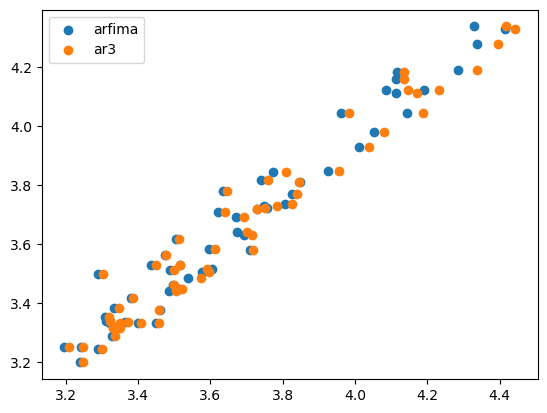

In [128]:
import matplotlib.pyplot as plt 
plt.scatter(df_final['arfima'],df_final['true'],label='arfima')
plt.scatter(df_final['ar3'],df_final['true'],label='ar3')
plt.legend()
plt.show()